In [35]:
# ติดตั้ง Java และ Spark ใน Google Colab
!apt-get update
!apt-get install openjdk-8-jdk-headless -qq > /dev/null
!wget -q https://archive.apache.org/dist/spark/spark-3.2.0/spark-3.2.0-bin-hadoop3.2.tgz
!tar xf spark-3.2.0-bin-hadoop3.2.tgz
!pip install -q findspark


Get:1 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease [3,632 B]
Get:2 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease [1,581 B]
Get:3 https://r2u.stat.illinois.edu/ubuntu jammy InRelease [6,555 B]
Hit:4 http://archive.ubuntu.com/ubuntu jammy InRelease
Get:5 http://security.ubuntu.com/ubuntu jammy-security InRelease [129 kB]
Get:6 http://archive.ubuntu.com/ubuntu jammy-updates InRelease [128 kB]
Get:7 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ Packages [77.5 kB]
Get:8 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  Packages [1,659 kB]
Hit:9 https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu jammy InRelease
Get:10 https://r2u.stat.illinois.edu/ubuntu jammy/main all Packages [8,911 kB]
Hit:11 https://ppa.launchpadcontent.net/graphics-drivers/ppa/ubuntu jammy InRelease
Hit:12 https://ppa.launchpadcontent.net/ubuntugis/ppa/ubuntu jammy InRelease
Get:13 http://archive.ubuntu.com/ubuntu 

In [36]:
import os
import findspark

# กำหนดที่อยู่ของ Spark
os.environ["SPARK_HOME"] = "/content/spark-3.2.0-bin-hadoop3.2"
findspark.init()

from pyspark.sql import SparkSession

# สร้าง Spark session
spark = SparkSession.builder.master("local[*]").getOrCreate()


In [62]:
from google.colab import files

# อัปโหลดไฟล์จากคอมพิวเตอร์ของคุณ
uploaded = files.upload()




Saving ml.csv to ml.csv


In [63]:
import os

# ตรวจสอบว่ามีไฟล์ในโฟลเดอร์ที่กำหนดหรือไม่
print(os.listdir('/content'))


['.config', 'spark-3.2.0-bin-hadoop3.2.tgz', 'top.csv', 'smartphone_sales_data.csv', 'smartphone_sales_data.xlsx', 'spark-3.2.0-bin-hadoop3.2', 'ml.csv', 'sample_data']


In [64]:
file_path = '/content/ml.csv'

# โหลดข้อมูลด้วย PySpark
vendor_data = spark.read.csv(file_path, header=True, inferSchema=True)

# แสดงข้อมูลบางส่วน
vendor_data.show(5)


+-------------+----------------------------------------+
|Device Vendor|Market Share Perc. (Jan 2014 - Dec 2024)|
+-------------+----------------------------------------+
|      Samsung|                                   30.47|
|        Apple|                                    23.1|
|      Unknown|                                    7.59|
|       Xiaomi|                                    5.66|
|       Huawei|                                    5.03|
+-------------+----------------------------------------+
only showing top 5 rows



In [68]:
from pyspark.ml.feature import VectorAssembler
from pyspark.ml import Pipeline

# สมมุติว่าใช้ 'Month', 'Year' เป็น feature
# และ 'Revenue' เป็น target (ต้องตรวจสอบให้แน่ใจว่าคอลัมน์ 'Revenue' มีอยู่ในข้อมูลของคุณ)
# ใช้ backticks (``) เพื่ออ้างอิงชื่อคอลัมน์ที่มีช่องว่างหรือเครื่องหมายพิเศษ
data = vendor_data.select("`Device Vendor`", "`Market Share Perc. (Jan 2014 - Dec 2024)`")

# แสดงข้อมูลบางส่วน
data.show(5)

+-------------+----------------------------------------+
|Device Vendor|Market Share Perc. (Jan 2014 - Dec 2024)|
+-------------+----------------------------------------+
|      Samsung|                                   30.47|
|        Apple|                                    23.1|
|      Unknown|                                    7.59|
|       Xiaomi|                                    5.66|
|       Huawei|                                    5.03|
+-------------+----------------------------------------+
only showing top 5 rows



In [74]:
# แสดงชื่อคอลัมน์ทั้งหมด
print(vendor_data.columns)


['Device Vendor', 'Market Share Perc. (Jan 2014 - Dec 2024)']


In [78]:
# เปลี่ยนชื่อคอลัมน์ที่มีช่องว่างหรืออักขระพิเศษ
vendor_data = vendor_data.withColumnRenamed("Device Vendor", "Device_Vendor") \
                         .withColumnRenamed("Market Share Perc. (Jan 2014 - Dec 2024)", "Market_Share_Perc")

# แสดงชื่อคอลัมน์ใหม่
print(vendor_data.columns)


['Device_Vendor', 'Market_Share_Perc']


In [82]:
from pyspark.ml.feature import StringIndexer, VectorAssembler
from pyspark.ml.regression import LinearRegression

# แปลงคอลัมน์ 'Device_Vendor' ให้เป็นตัวเลข
indexer = StringIndexer(inputCol="Device_Vendor", outputCol="Device_Vendor_Index")
vendor_data_indexed = indexer.fit(vendor_data).transform(vendor_data)

# สร้าง VectorAssembler เพื่อรวม 'Device_Vendor_Index' เป็นฟีเจอร์
assembler = VectorAssembler(inputCols=["Device_Vendor_Index"], outputCol="features")

# แปลงข้อมูลให้เป็นเวกเตอร์
data = assembler.transform(vendor_data_indexed)

# สร้างโมเดล Linear Regression
lr = LinearRegression(featuresCol="features", labelCol="Market_Share_Perc")

# ฝึกโมเดล
lr_model = lr.fit(data)

# ทำนายผล
predictions = lr_model.transform(data)

# แสดงผลการทำนาย
predictions.select("Device_Vendor", "Market_Share_Perc", "prediction").show(5)


+-------------+-----------------+------------------+
|Device_Vendor|Market_Share_Perc|        prediction|
+-------------+-----------------+------------------+
|      Samsung|            30.47|1.3913823812439856|
|        Apple|             23.1|1.5217849706937283|
|      Unknown|             7.59|1.3587817338815498|
|       Xiaomi|             5.66|1.3439632578077154|
|       Huawei|             5.03|1.4743658472574583|
+-------------+-----------------+------------------+
only showing top 5 rows



In [84]:
# สร้างโมเดล Linear Regression
lr = LinearRegression(featuresCol="features", labelCol="Market_Share_Perc")

# ฝึกโมเดล
lr_model = lr.fit(data)

# ทำนายผล
predictions = lr_model.transform(data)

# แสดงผลการทำนาย
predictions.select("Device_Vendor", "Market_Share_Perc", "prediction").show(5)


+-------------+-----------------+------------------+
|Device_Vendor|Market_Share_Perc|        prediction|
+-------------+-----------------+------------------+
|      Samsung|            30.47|1.3913823812439856|
|        Apple|             23.1|1.5217849706937283|
|      Unknown|             7.59|1.3587817338815498|
|       Xiaomi|             5.66|1.3439632578077154|
|       Huawei|             5.03|1.4743658472574583|
+-------------+-----------------+------------------+
only showing top 5 rows



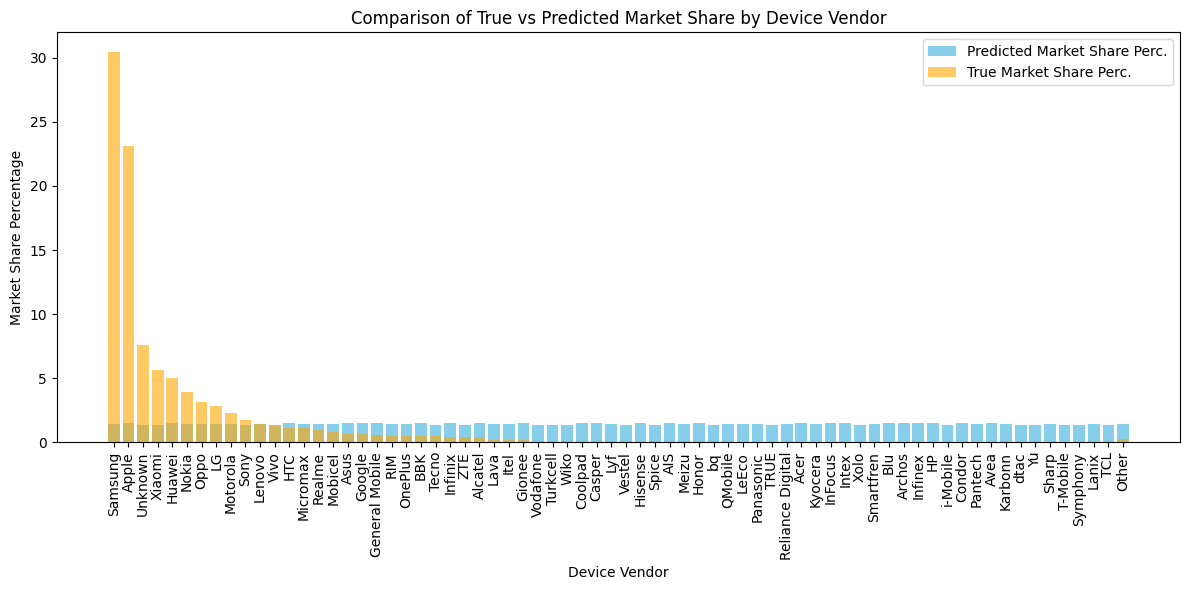

In [93]:
# แปลงข้อมูลจาก PySpark DataFrame เป็น Pandas DataFrame
predictions_pd = predictions.select("Device_Vendor", "Market_Share_Perc", "prediction").toPandas()

# สร้าง Bar Chart แสดงผลการทำนาย
plt.figure(figsize=(12,6))
plt.bar(predictions_pd['Device_Vendor'], predictions_pd['prediction'], color='skyblue', label="Predicted Market Share Perc.")
plt.bar(predictions_pd['Device_Vendor'], predictions_pd['Market_Share_Perc'], alpha=0.6, color='orange', label="True Market Share Perc.")
plt.title('Comparison of True vs Predicted Market Share by Device Vendor')
plt.xlabel('Device Vendor')
plt.ylabel('Market Share Percentage')
plt.xticks(rotation=90)  # หมุนป้ายชื่อรุ่นโทรศัพท์เพื่อให้ดูง่าย
plt.legend()
plt.tight_layout()  # ปรับให้กราฟไม่ขยายออกจากขอบเขต
plt.show()
